# Exploring SHAP feature attributions in image classification


## Prepare to run the experiments

In [1]:
import torch
torch.manual_seed(42)

import random
random.seed(42)

import numpy as np
np.random.seed(42)

Import the modules we will use in the folllowing cells.

In [3]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 15.4 MB/s eta 0:00:00


##Model Definition 

In [6]:
"""Models and training/test fnuctions."""

import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

DEVICE = torch.device('cpu')
BATCH_SIZE = 128


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x


def optimizer(model):
    return optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output.log(), target).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
        transforms.ToTensor()
    ])),
    batch_size=BATCH_SIZE, shuffle=True)


def train_model(model, num_epochs):
    opt = optimizer(model)
    for epoch in range(1, num_epochs + 1):
        train(model, DEVICE, train_loader, opt, epoch)
        test(model, DEVICE, test_loader)

100%|██████████| 9912422/9912422 [00:00<00:00, 83315387.17it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 15836801.39it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41787610.93it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 14609301.20it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [7]:
import shap
import numpy as np
import matplotlib.pyplot as plt


## Experiment 1 - accurate network

In this experiment we train a network to a (fairly) accurate level, then use SHAP to explain the feature attributions for the network predictions.

The goal of this section is to explore how SHAP feature attribution works. In other words, to explore if we can understand how the network is making the predictions.

### Train the network

This step may take several minutes on a CPU. It will show the results of each epoch as they finish.

In [9]:
model_accurate = Net().to(DEVICE)
train_model(model_accurate, 8)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.323686
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.831823
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.738681

Test set: Average loss: 0.0050, Accuracy: 8841/10000 (88%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.598536
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.741855
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.615565

Test set: Average loss: 0.0026, Accuracy: 9327/10000 (93%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.438568
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.448668
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.303330

Test set: Average loss: 0.0020, Accuracy: 9437/10000 (94%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.411436
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.267037
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.325486

Test set: Average loss: 0.0016, Accuracy: 9541/10000 (95%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.317591
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.247909
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.350961

Test set: Average loss: 0.0015

### Prepare a batch of images for feature attribution

Extract a batch of images and their labels from the test set.

In [11]:
images, targets = next(iter(test_loader))

"Select a set of background examples to take an expectation over" (from the [SHAP README](https://github.com/slundberg/shap#deep-learning-example-with-deepexplainer-tensorflowkeras-models))

In [12]:
BACKGROUND_SIZE = 100
background_images = images[:BACKGROUND_SIZE]
background_targets = targets[:BACKGROUND_SIZE].numpy()

What is left from the test batch will be used to show feature attribution.

In [13]:
test_images = images[BACKGROUND_SIZE:]
test_targets = targets[BACKGROUND_SIZE:].numpy()

**TO INVESTIGATE**: the way I understand how SHAP works, it would be more precise in the attributions if the background images had an equal number of samples for each class (digit). However, because we are using the test set loader, we get a random sample of the images. To try later: modify the code to load an equal number of images for each class.

For now, we will just check the distribution of the images and eyeball if we are getting a similar percentage of digits in the background image list. Ideally, we would have 10% of the samples for each digit, but because of the random sampling the percentages will vary. We are just trying to avoid extreme cases, where some digits have very low percentages or are not represented at all.

In [14]:
print('Digit:      ', end='')
[print('{:6}'.format(x), end='') for x in range(0, 10)];
print('\nBackground: ', end='')
[print('{:6.1%}'.format(x), end='') 
    for x in np.bincount(background_targets)/background_targets.shape[0]];
print('\nTest:       ', end='')
[print('{:6.1%}'.format(x), end='')
     for x in np.bincount(test_targets)/test_targets.shape[0]];

Digit:           0     1     2     3     4     5     6     7     8     9
Background:   9.0% 13.0%  9.0% 12.0%  7.0% 11.0% 11.0%  9.0% 17.0%  2.0%
Test:         7.1% 10.7% 17.9% 14.3% 10.7% 10.7% 10.7% 10.7%  3.6%  3.6%

### Show SHAP feature attributions

In [17]:
def show_attributions(model):
    # Predict the probabilities of the digits using the test images
    output = model(test_images.to(DEVICE))
    # Get the index of the max log-probability
    pred = output.max(1, keepdim=True)[1] 
    # Convert to numpy only once to save time
    pred_np = pred.numpy() 

    expl = shap.DeepExplainer(model, background_images)

    for i in range(0, len(test_images)):
        ti = test_images[[i]]
        sv = expl.shap_values(ti)
        sn = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in sv]
        tn = np.swapaxes(np.swapaxes(ti.numpy(), 1, -1), 1, 2)

        # Prepare the attribution plot, but do not draw it yet
        # We will add more info to the plots later in the code
        shap.image_plot(sn, -tn, show=False)

        # Prepare to augment the plot
        fig = plt.gcf()
        allaxes = fig.get_axes()

        # Show the actual/predicted class
        allaxes[0].set_title('Actual: {}, pred: {}'.format(
            test_targets[i], pred_np[i][0]))

        # Show the probability of each class
        # There are 11 axes for each picture: 1 for the digit + 10 for each SHAP
        # There is a last axis for the scale - we don't want to apply a label for that one
        prob = output[i].detach().numpy()
        for x in range(1, len(allaxes)-1):
            allaxes[x].set_title('{:.2%}'.format(prob[x-1]), fontsize=14)
        plt.show()

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


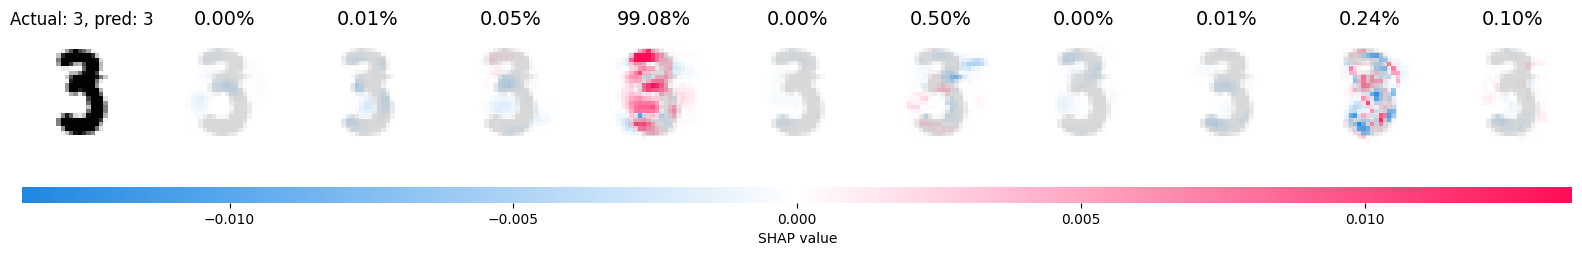

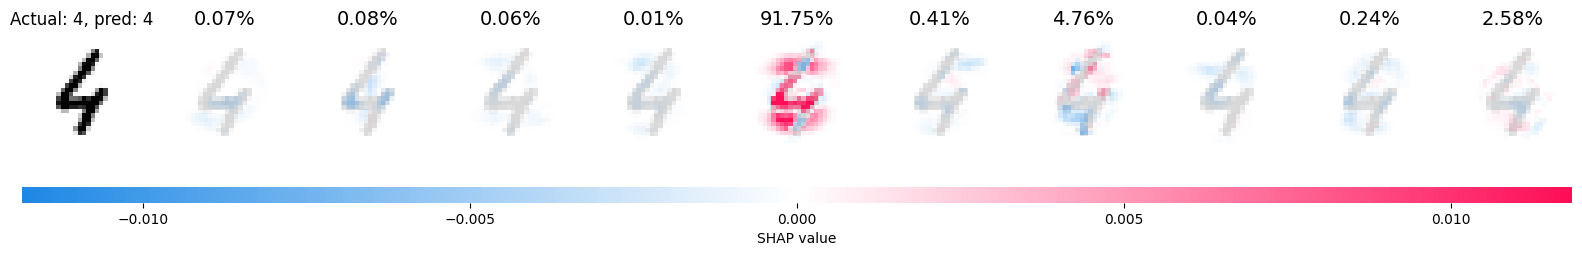

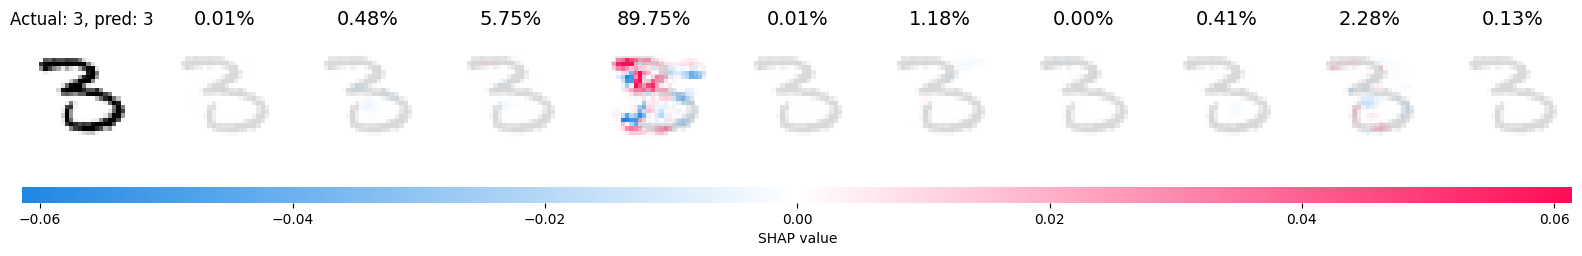

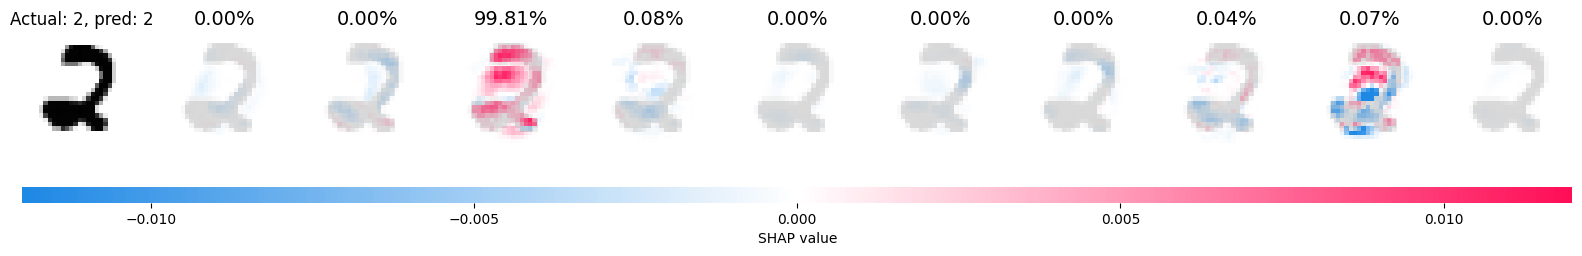

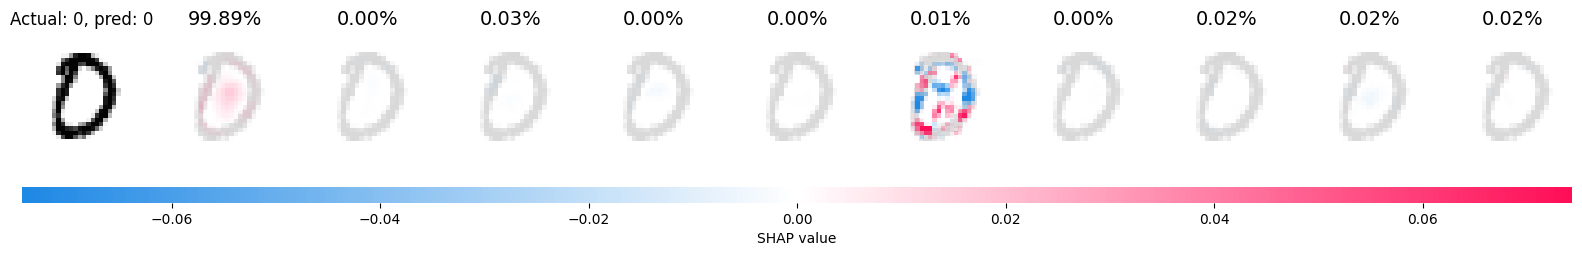

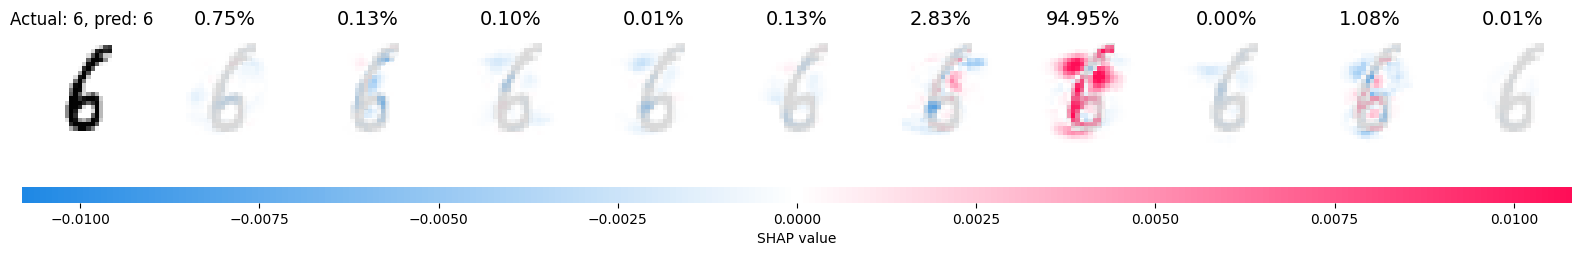

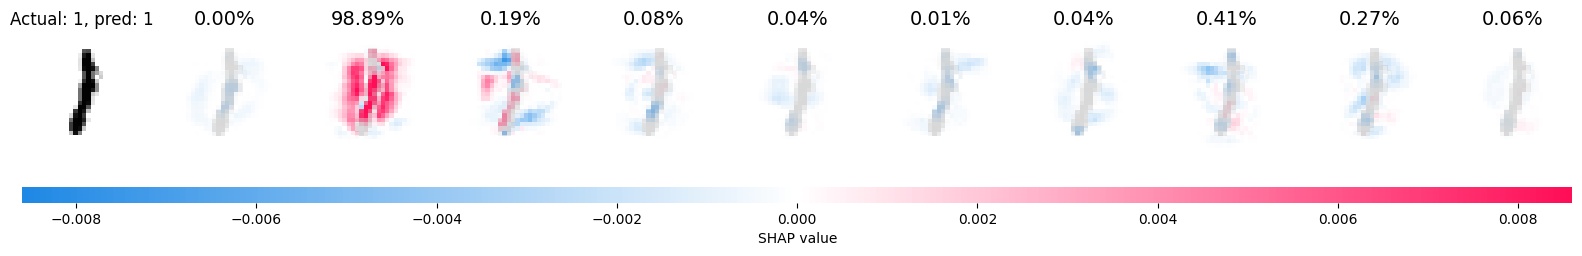

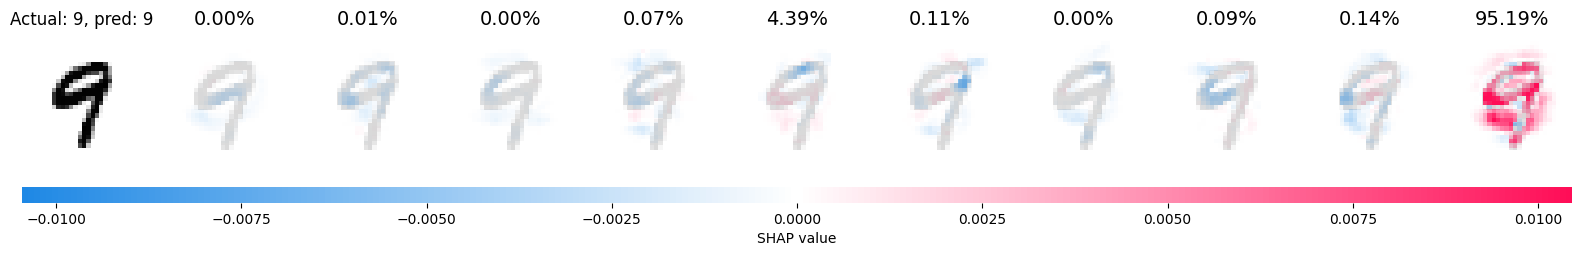

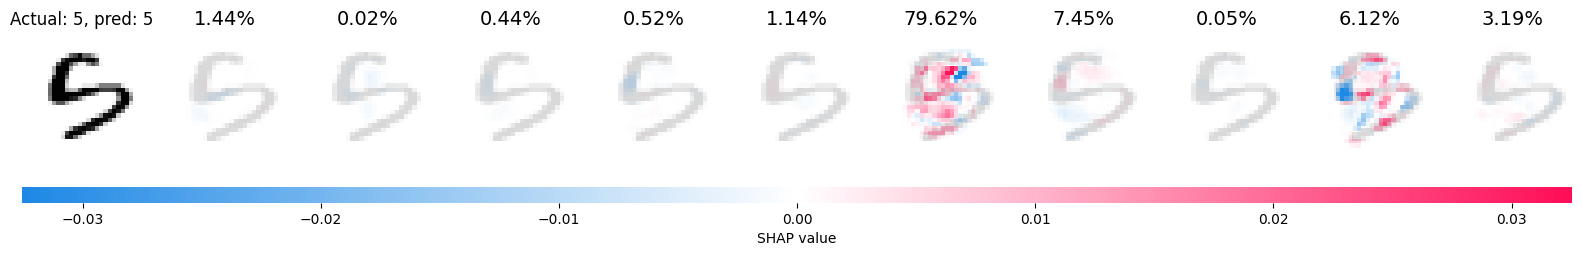

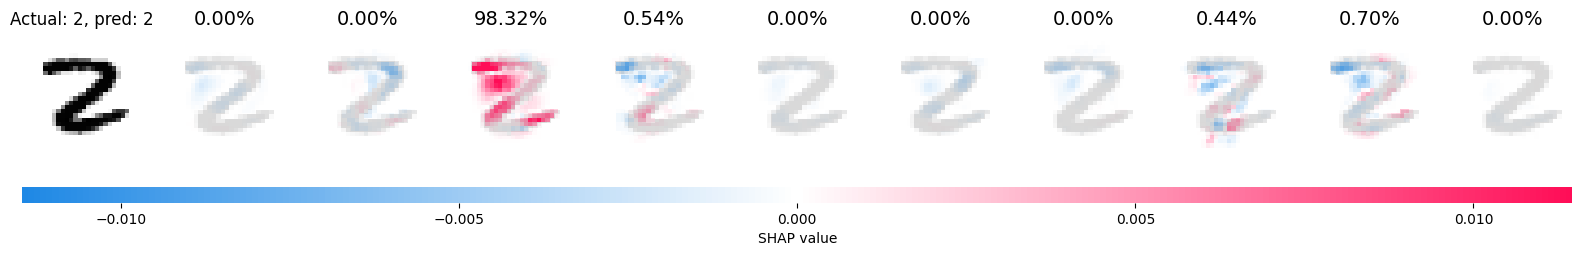

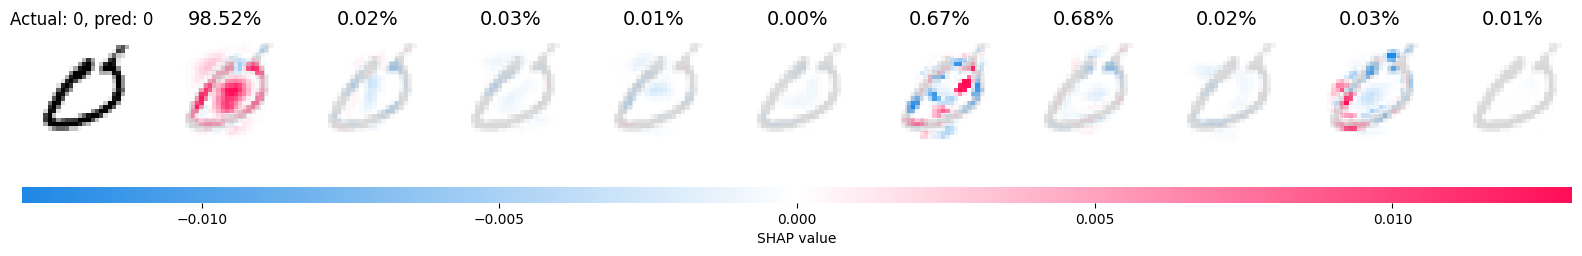

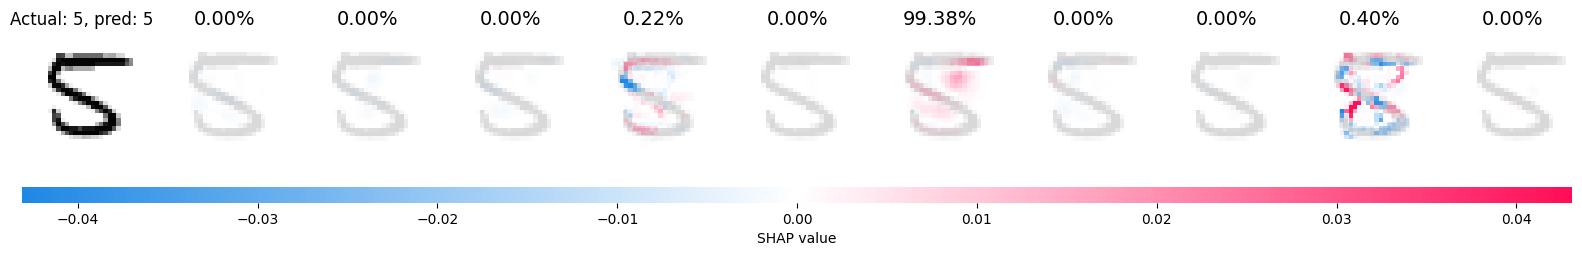

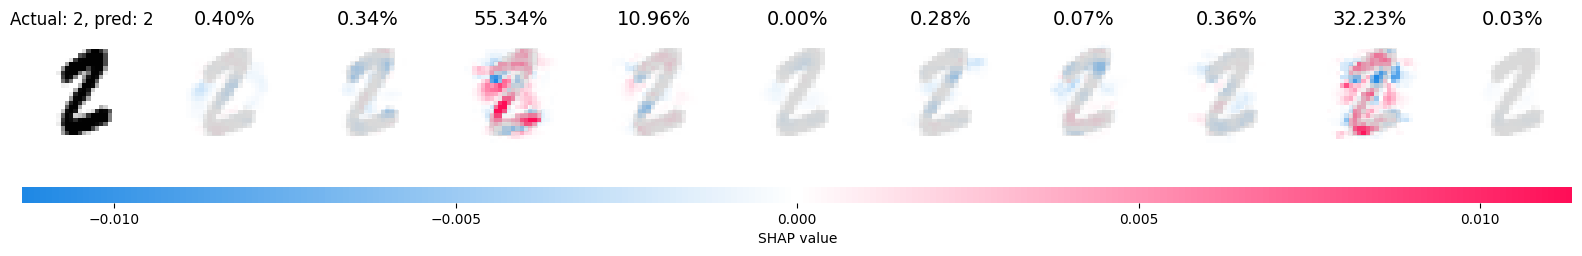

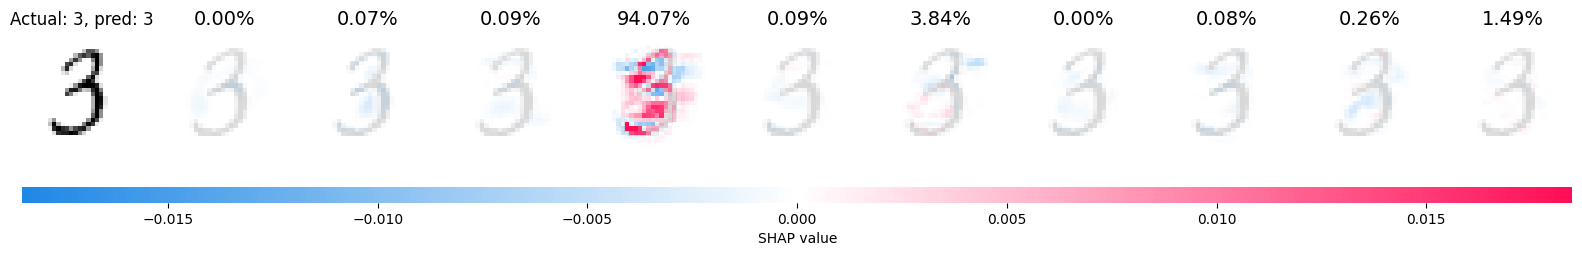

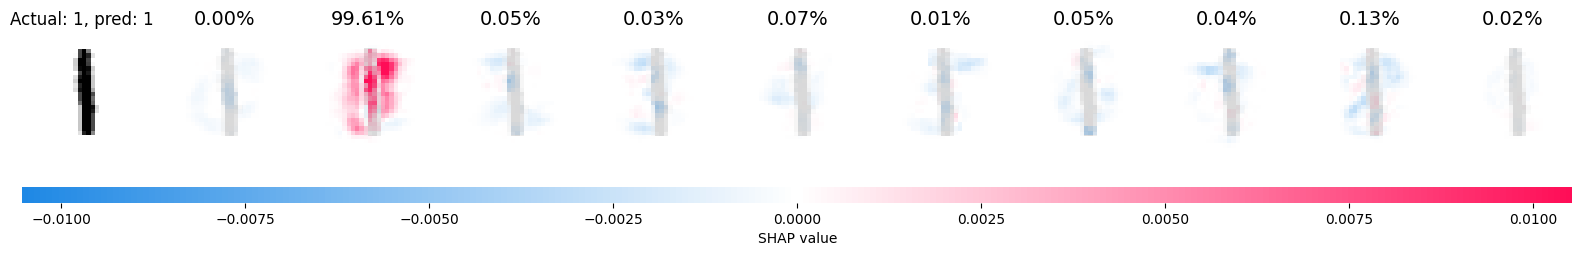

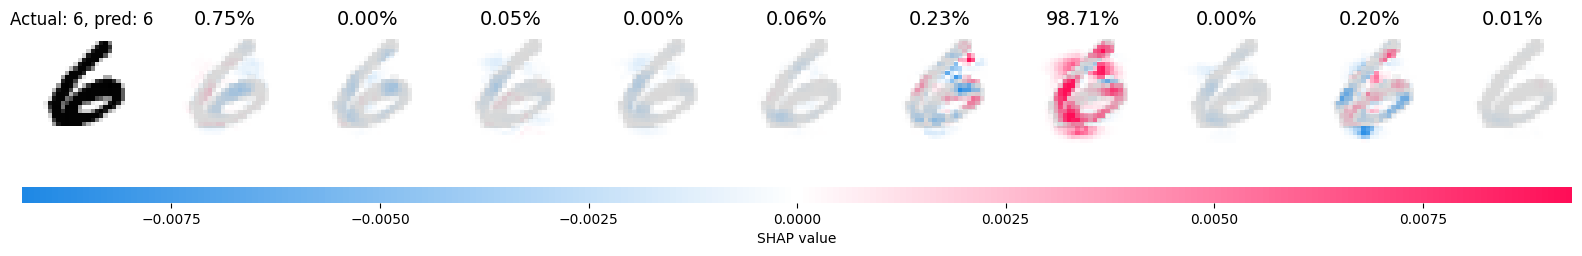

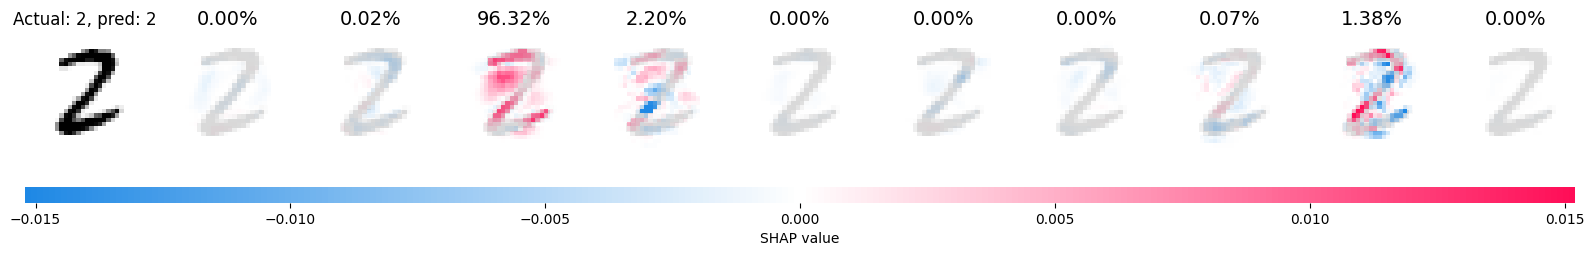

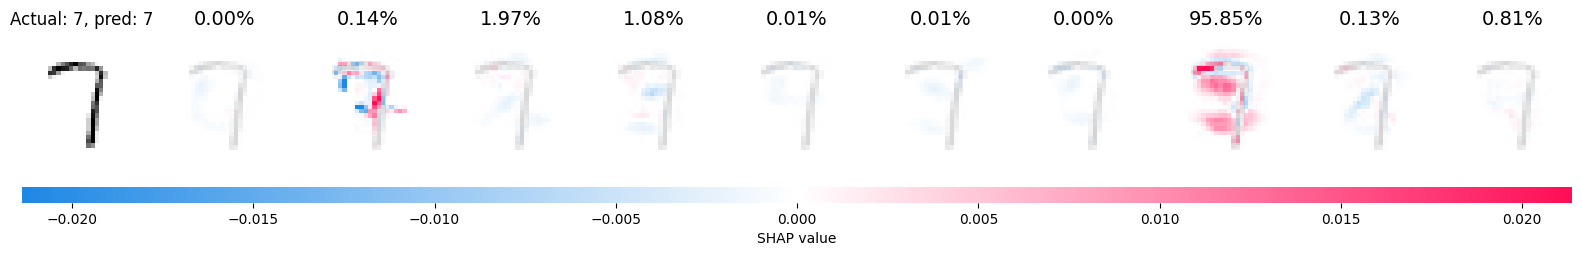

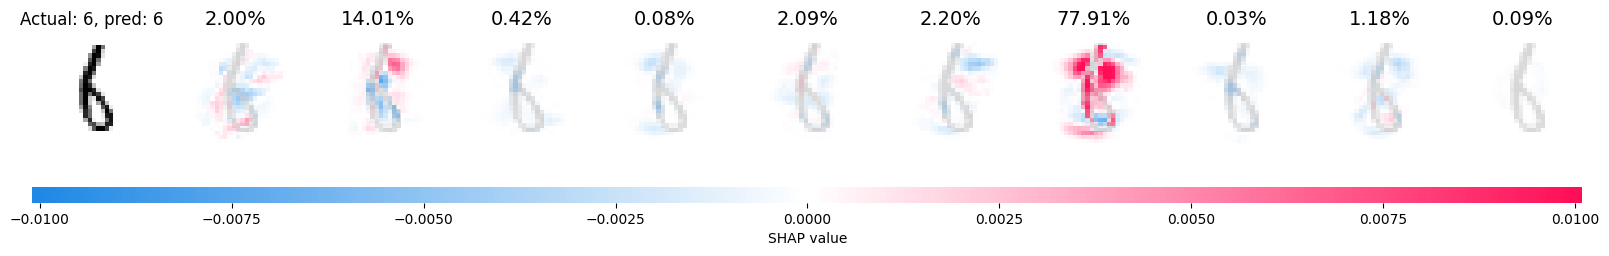

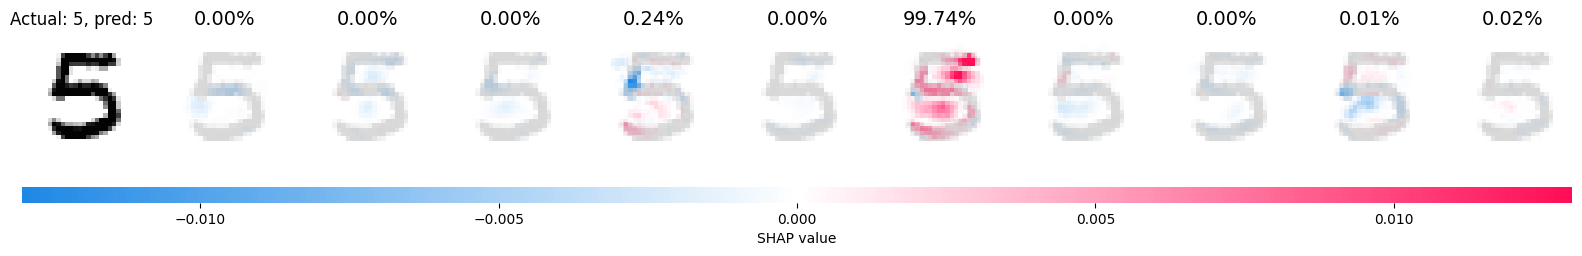

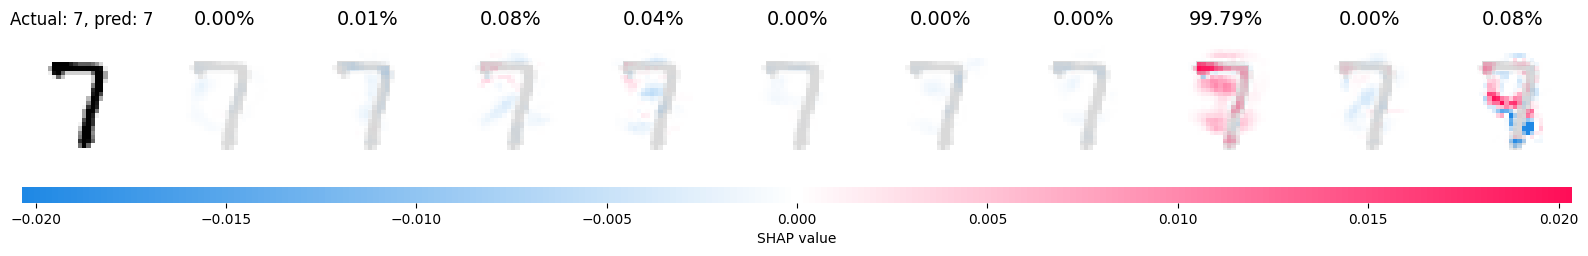

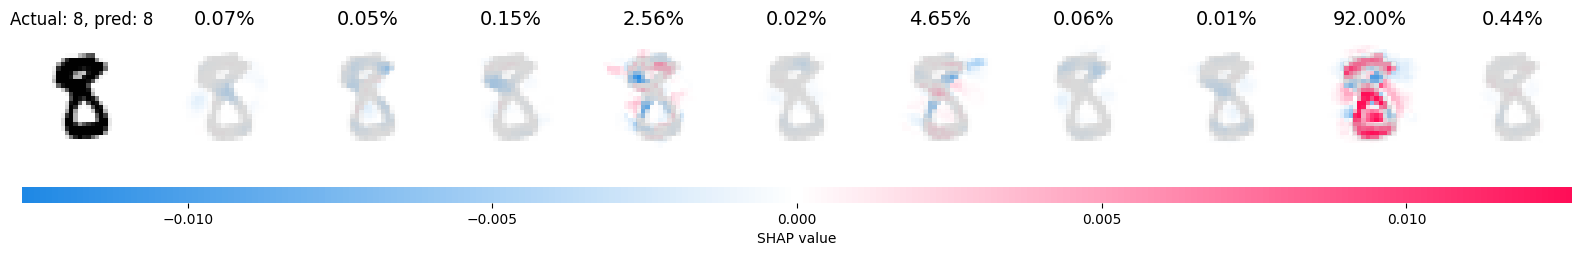

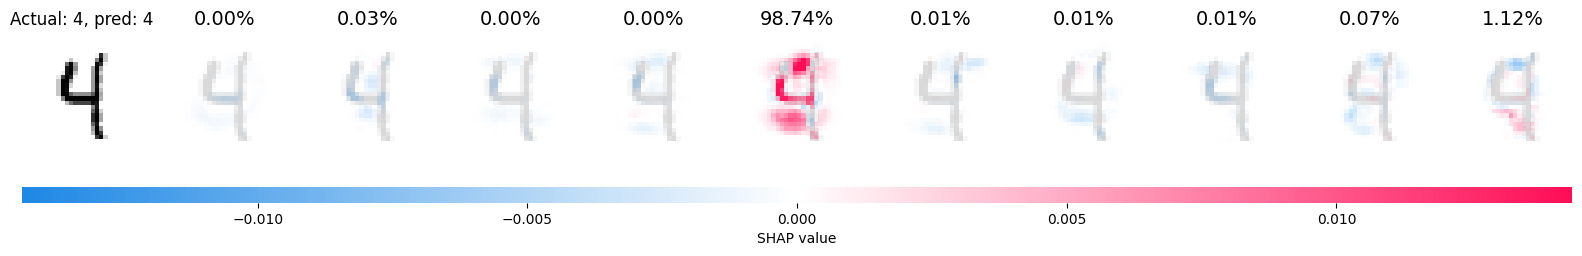

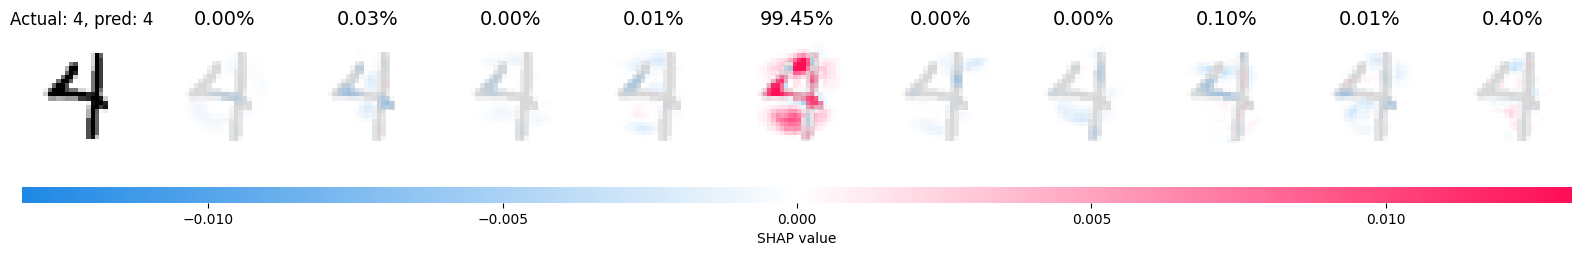

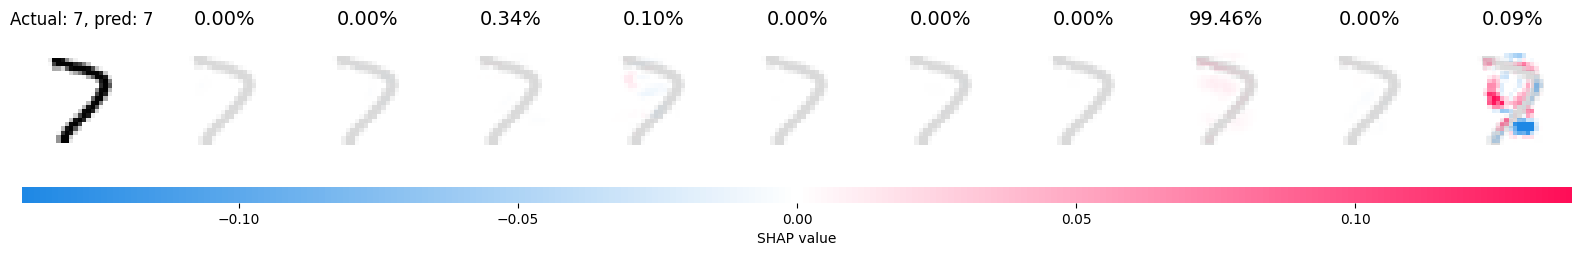

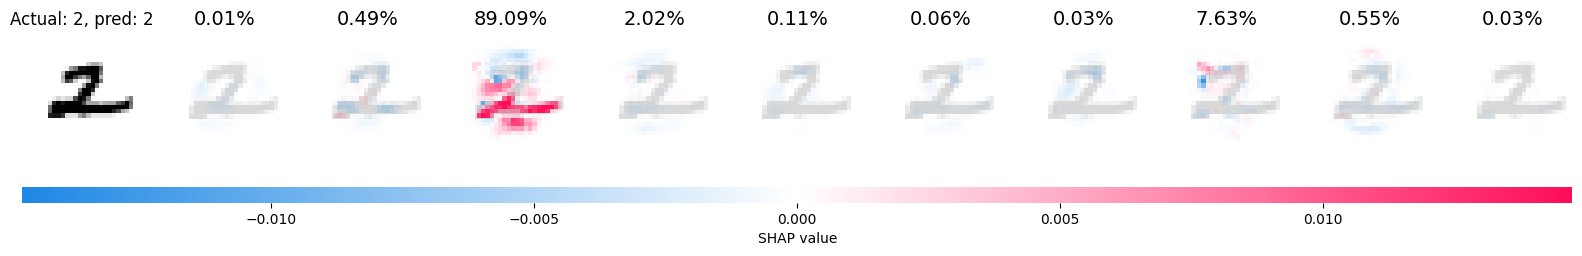

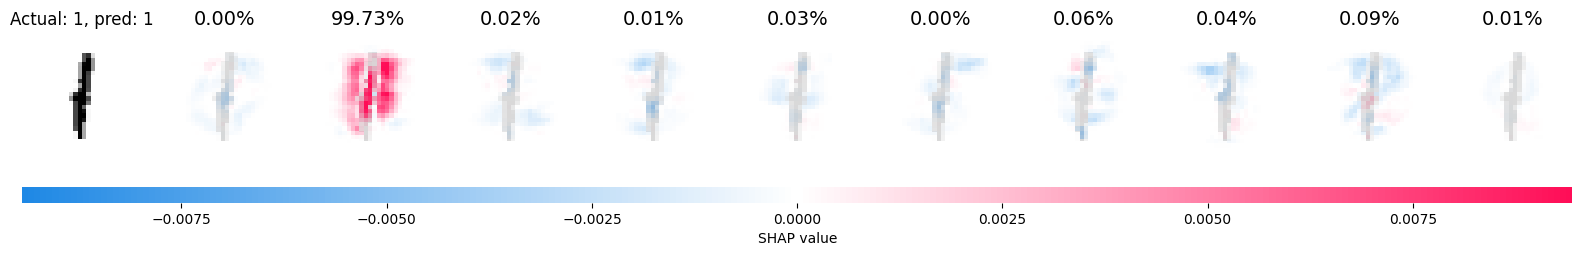

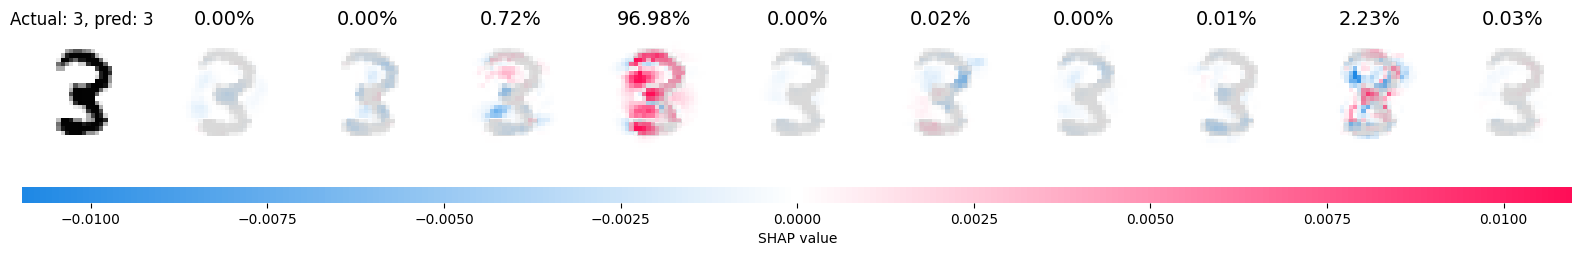

In [18]:
show_attributions(model_accurate)

## Experiment 2 - inaccurate network


### Train the network

This step is faster than the (fairly) accurate network by design. It trains for only one epoch to get a network that is not as accurate as the first one we trained (above).

In [19]:
model_inaccurate = Net().to(DEVICE)
train_model(model_inaccurate, 1)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.327801
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.186171
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.675983

Test set: Average loss: 0.0044, Accuracy: 8931/10000 (89%)



### Show SHAP feature attributions

Note that we reuse the same batch of images from the previous section. Holding the images constant allows us to compare the behavior of SHAP when only the model changes.

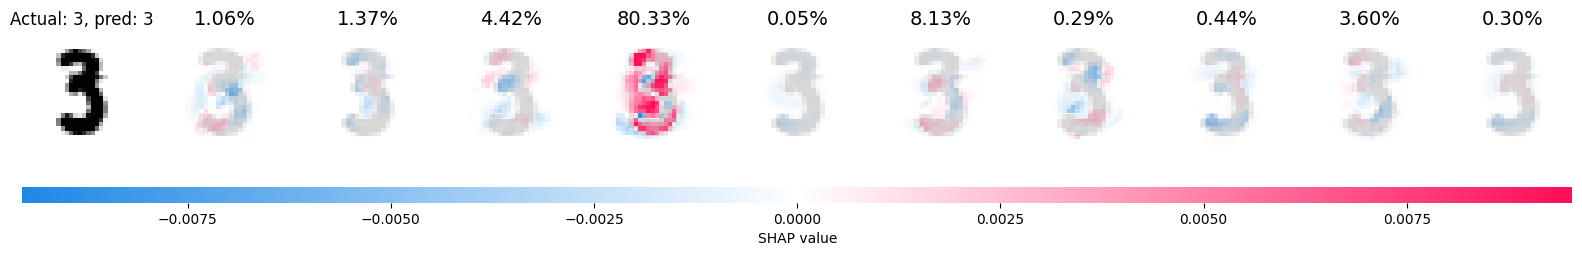

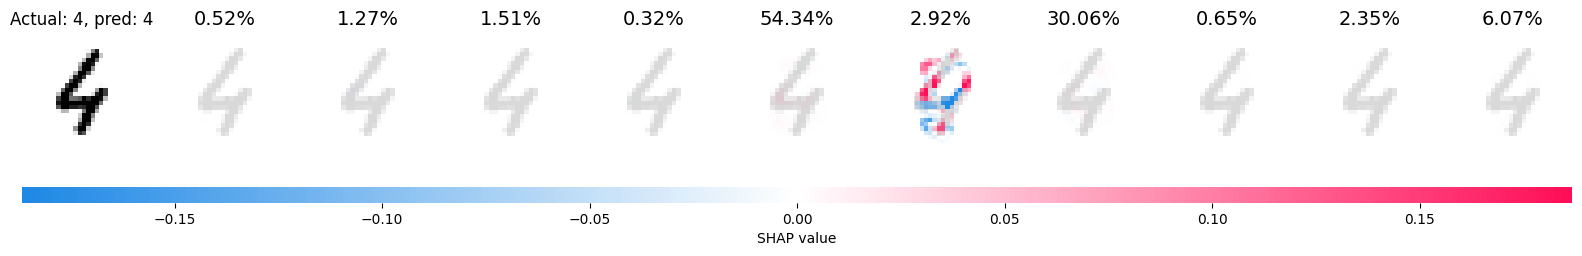

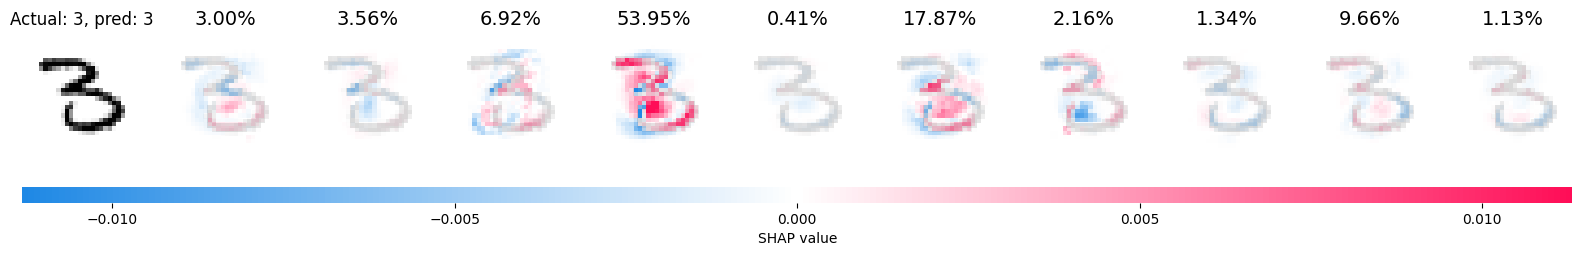

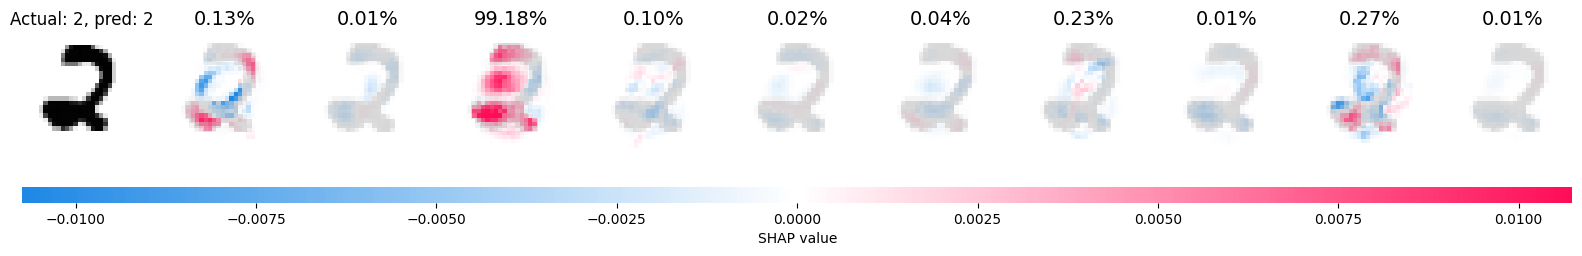

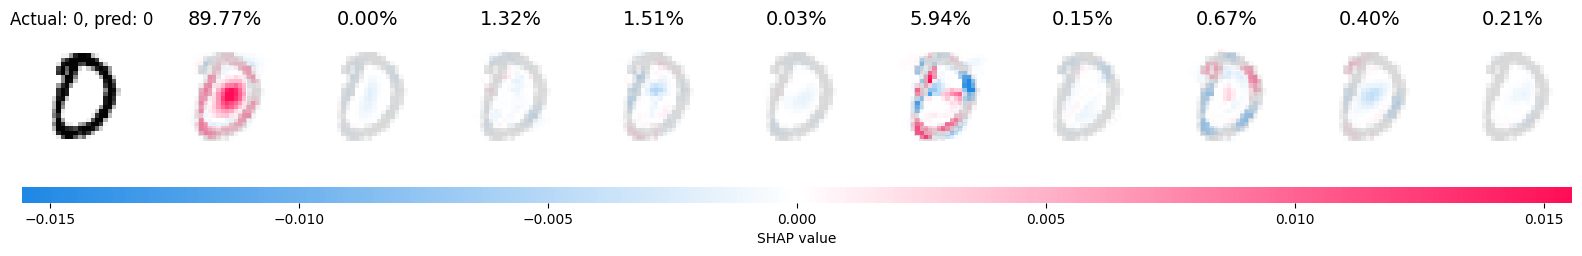

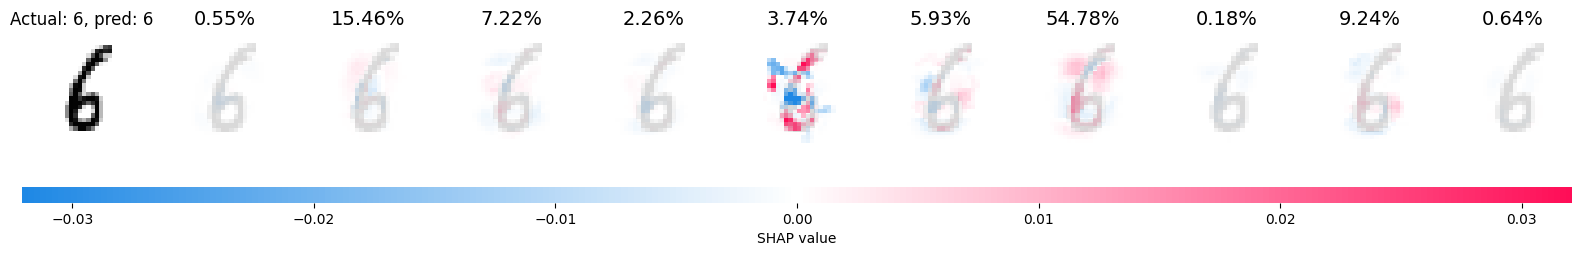

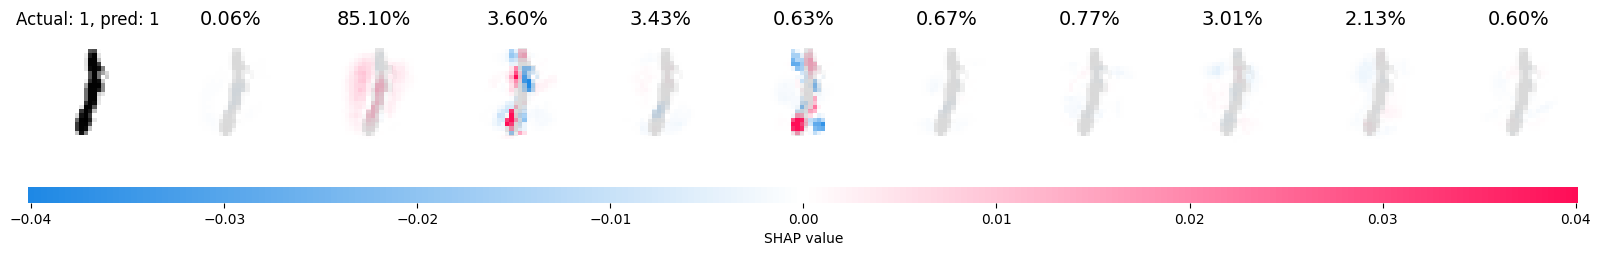

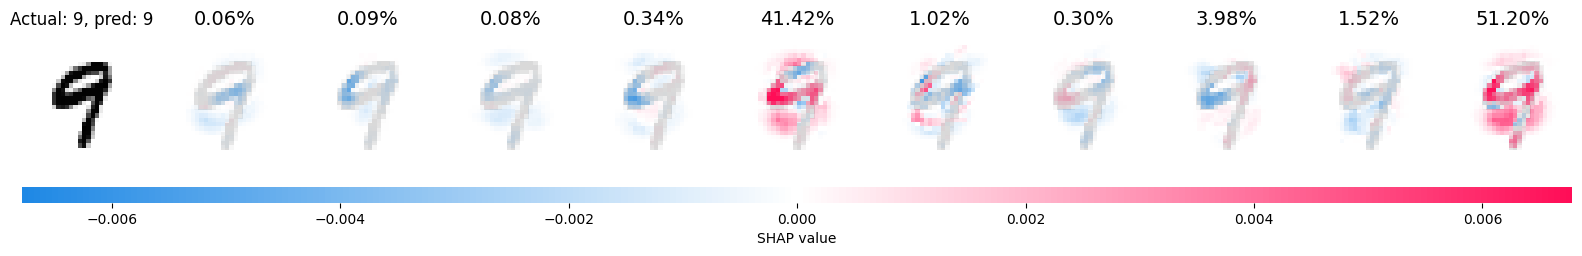

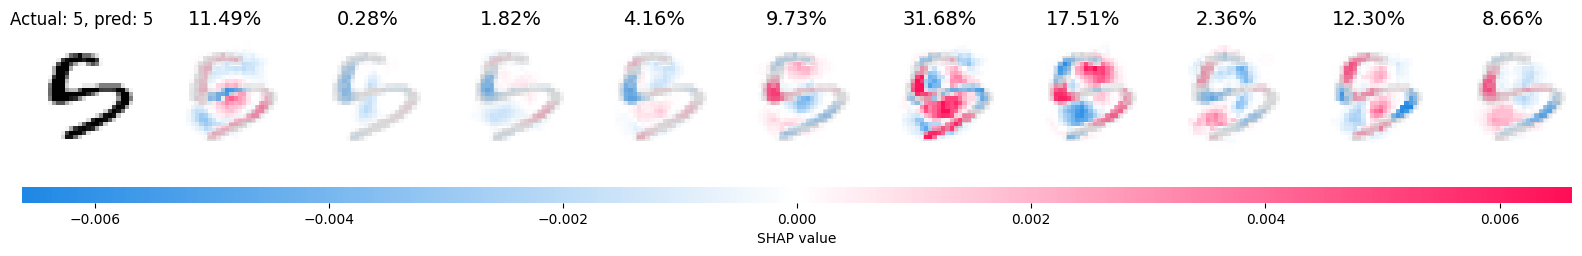

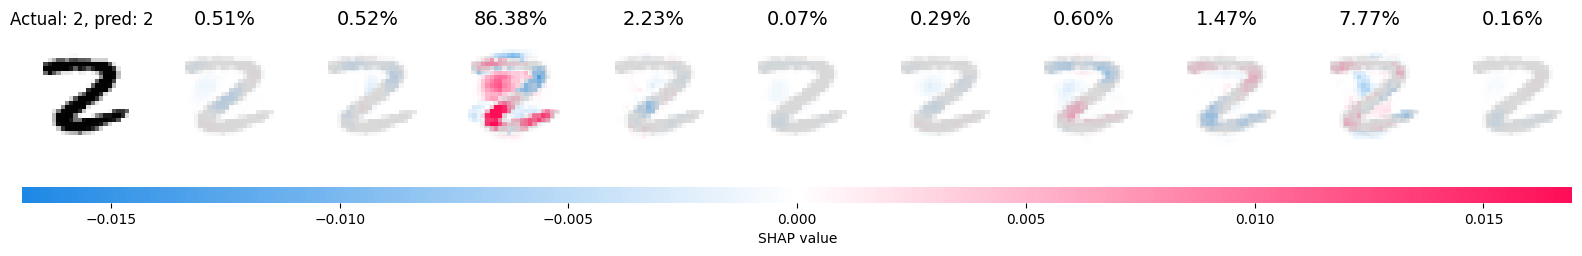

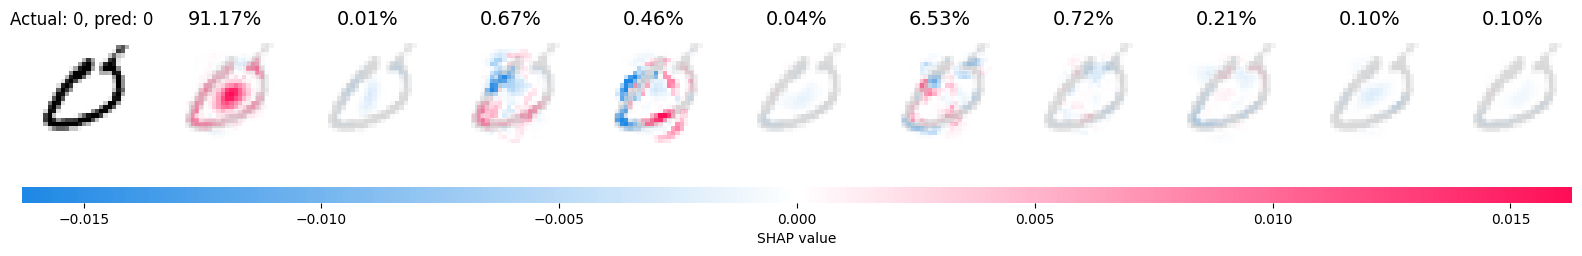

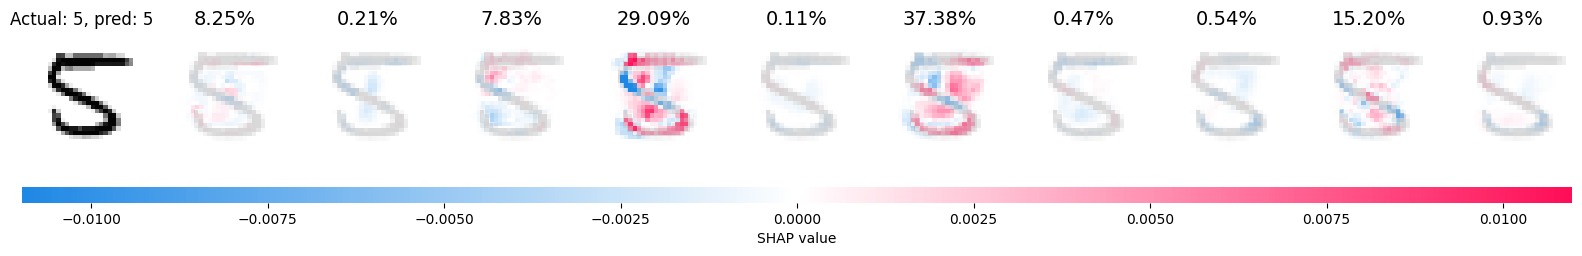

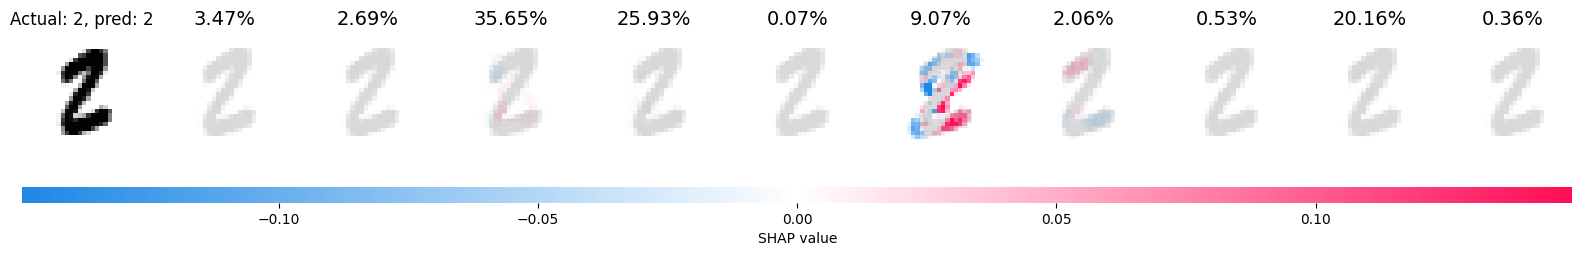

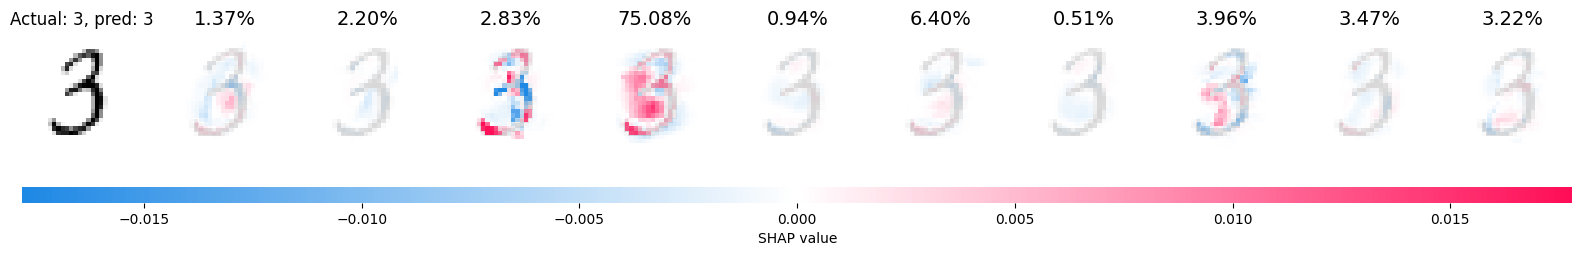

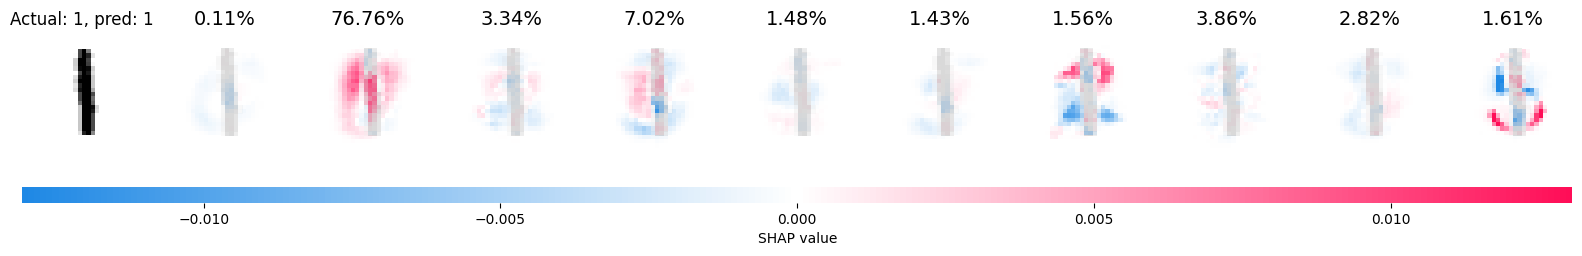

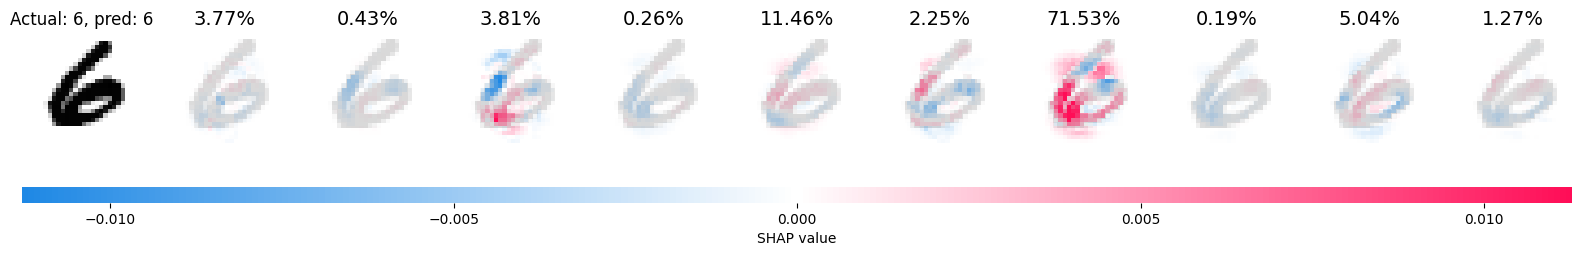

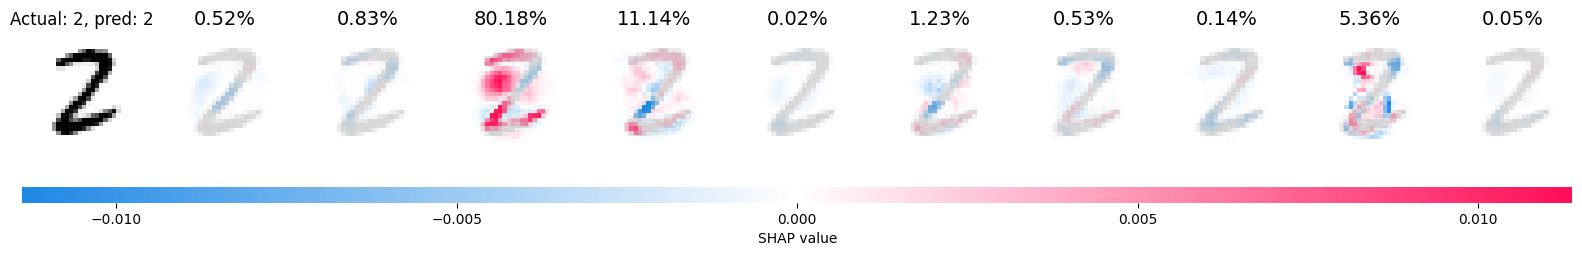

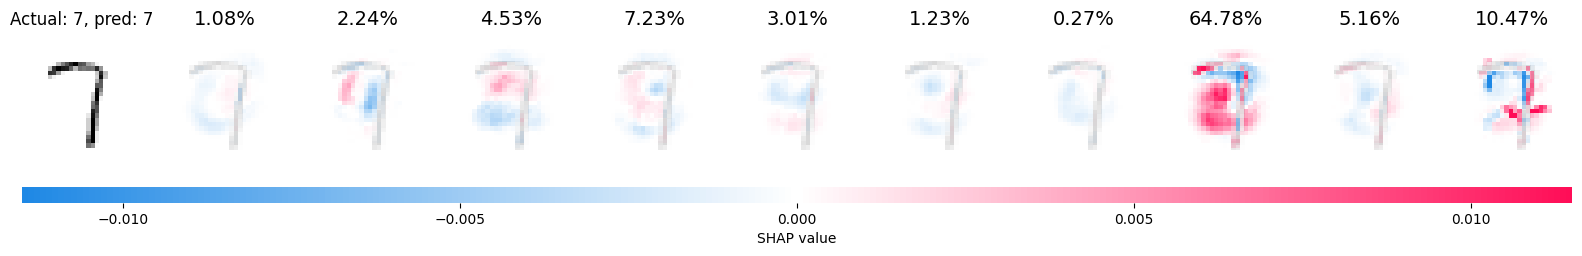

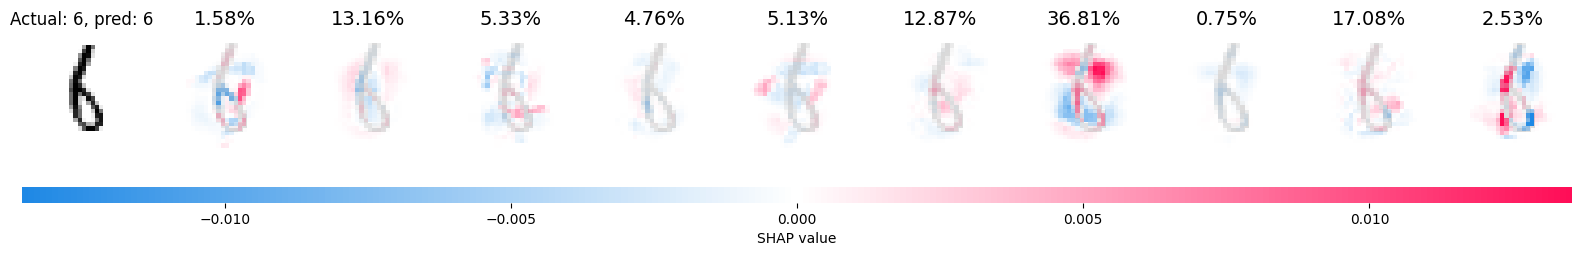

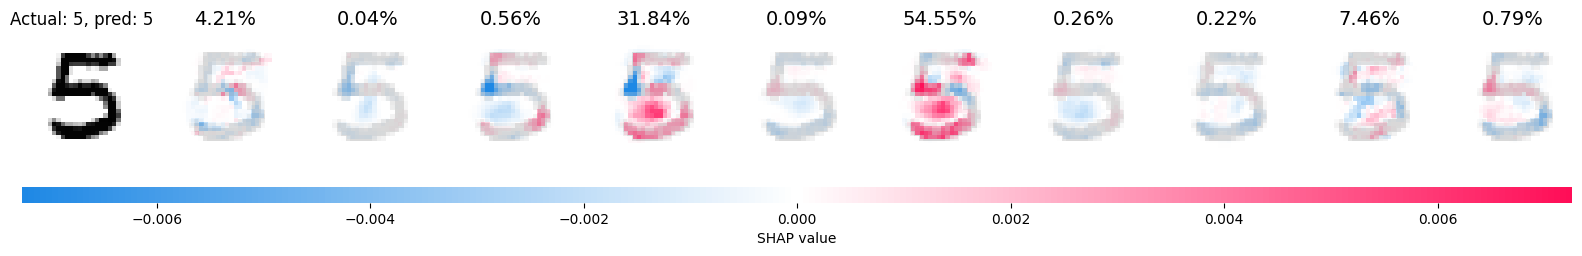

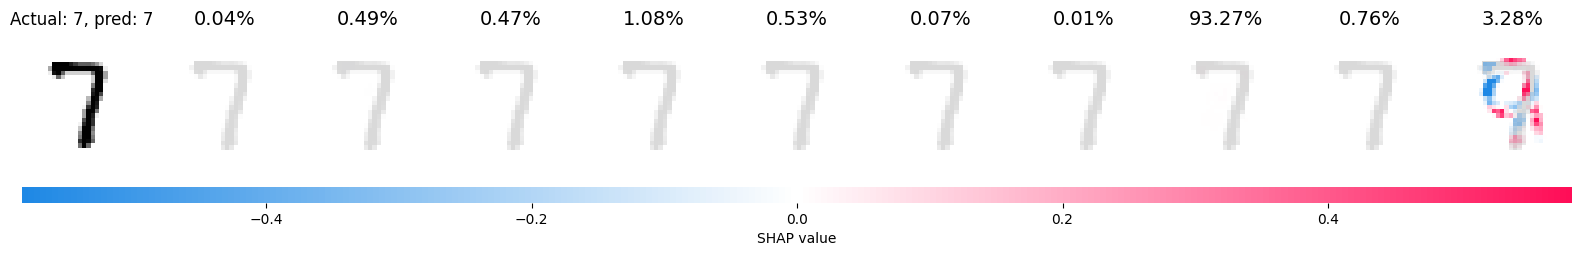

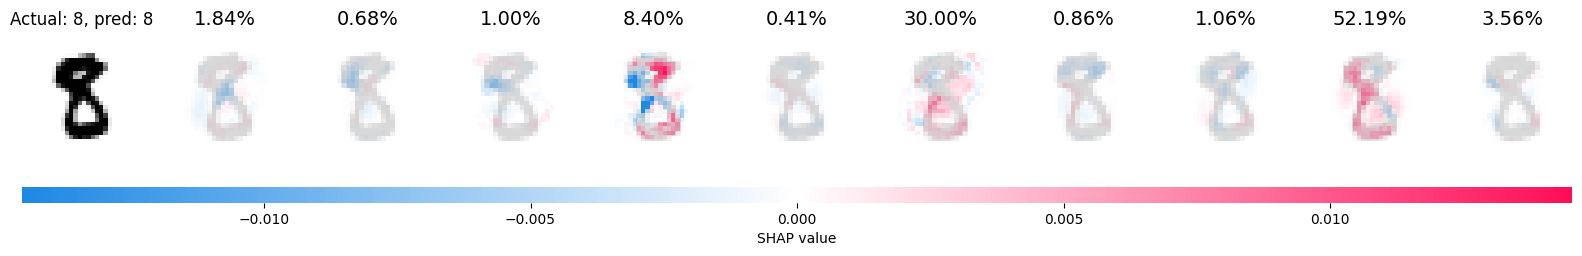

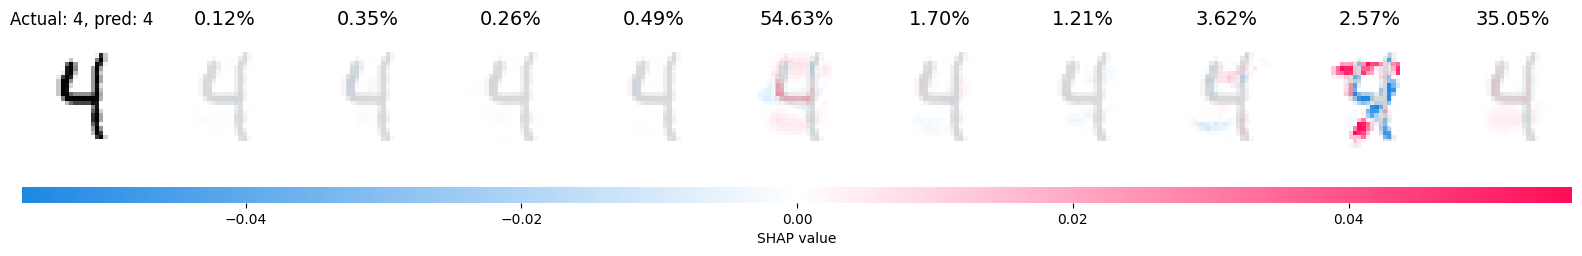

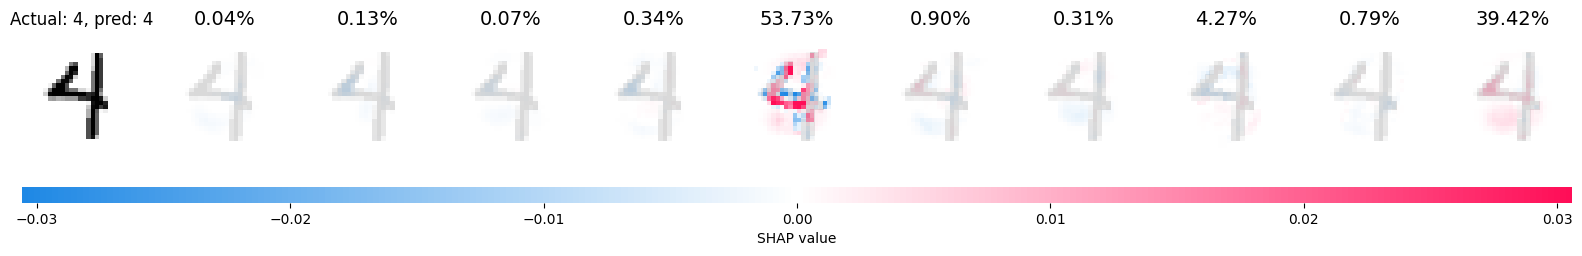

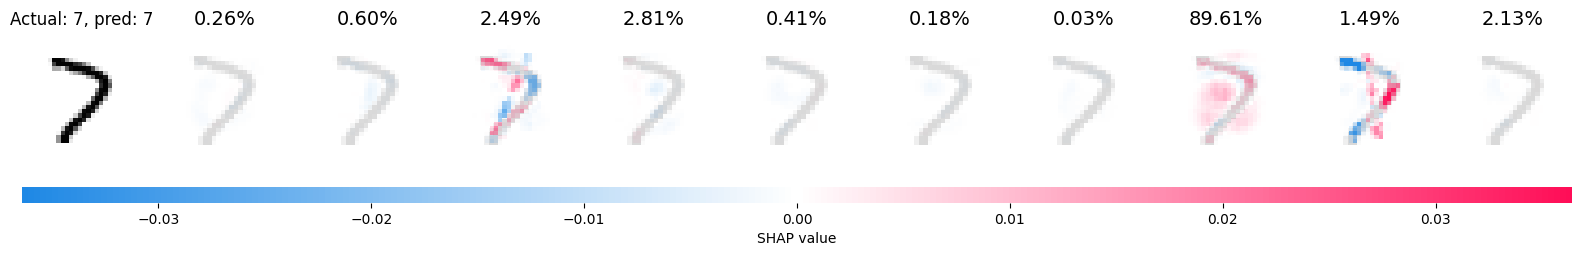

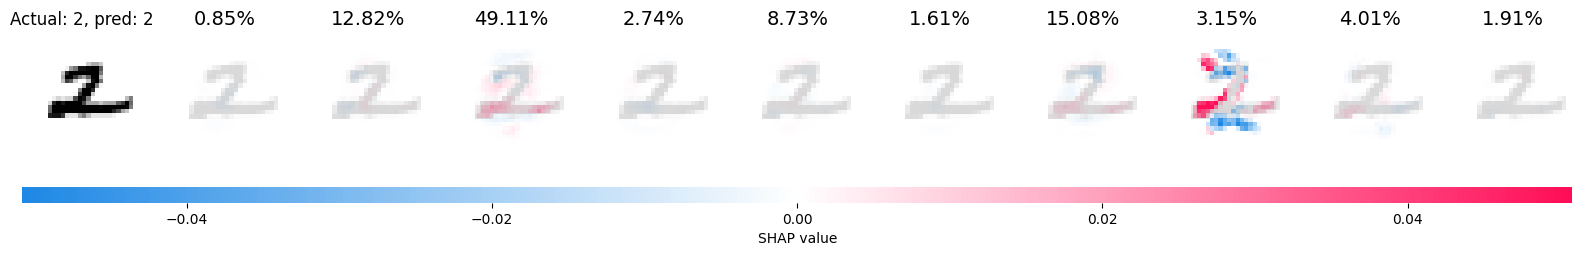

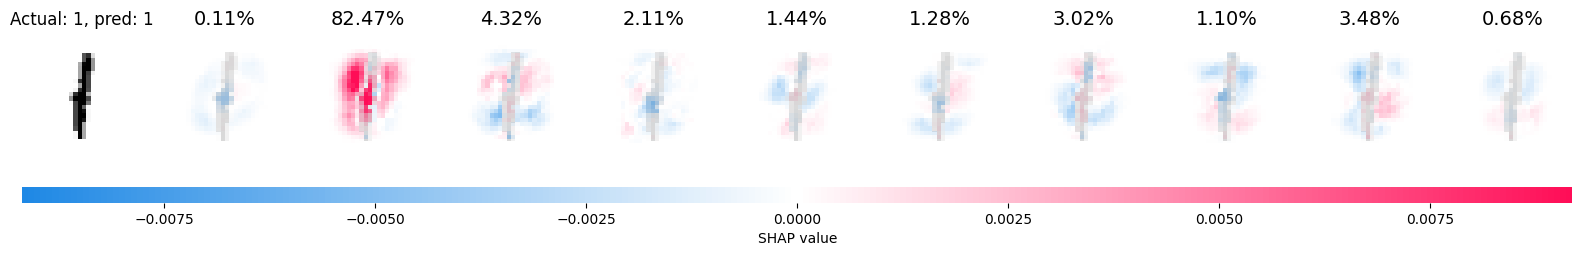

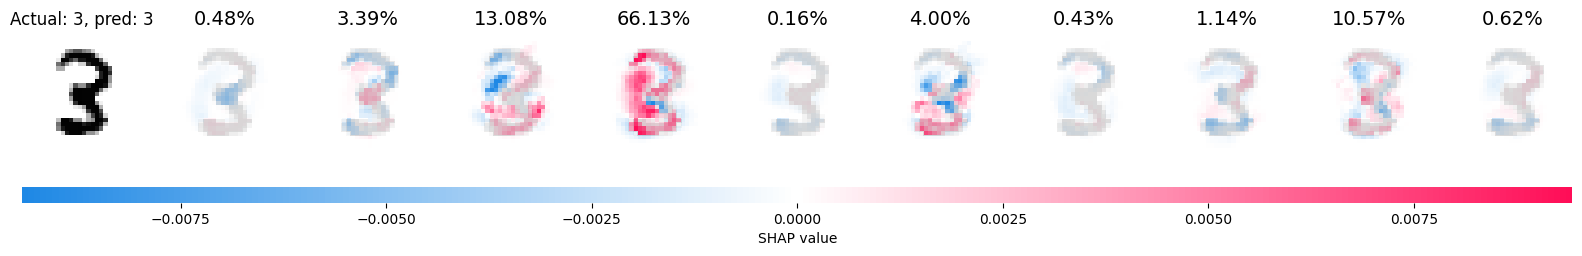

In [ ]:
show_attributions(model_inaccurate)

------

# Test code



In [ ]:
# Turn the test code on when needed to not pollute the notebook
TEST_CODE = True

# Model to test (uncomment one of them)
modelTest = model_accurate
#modelTest = model_inaccurate

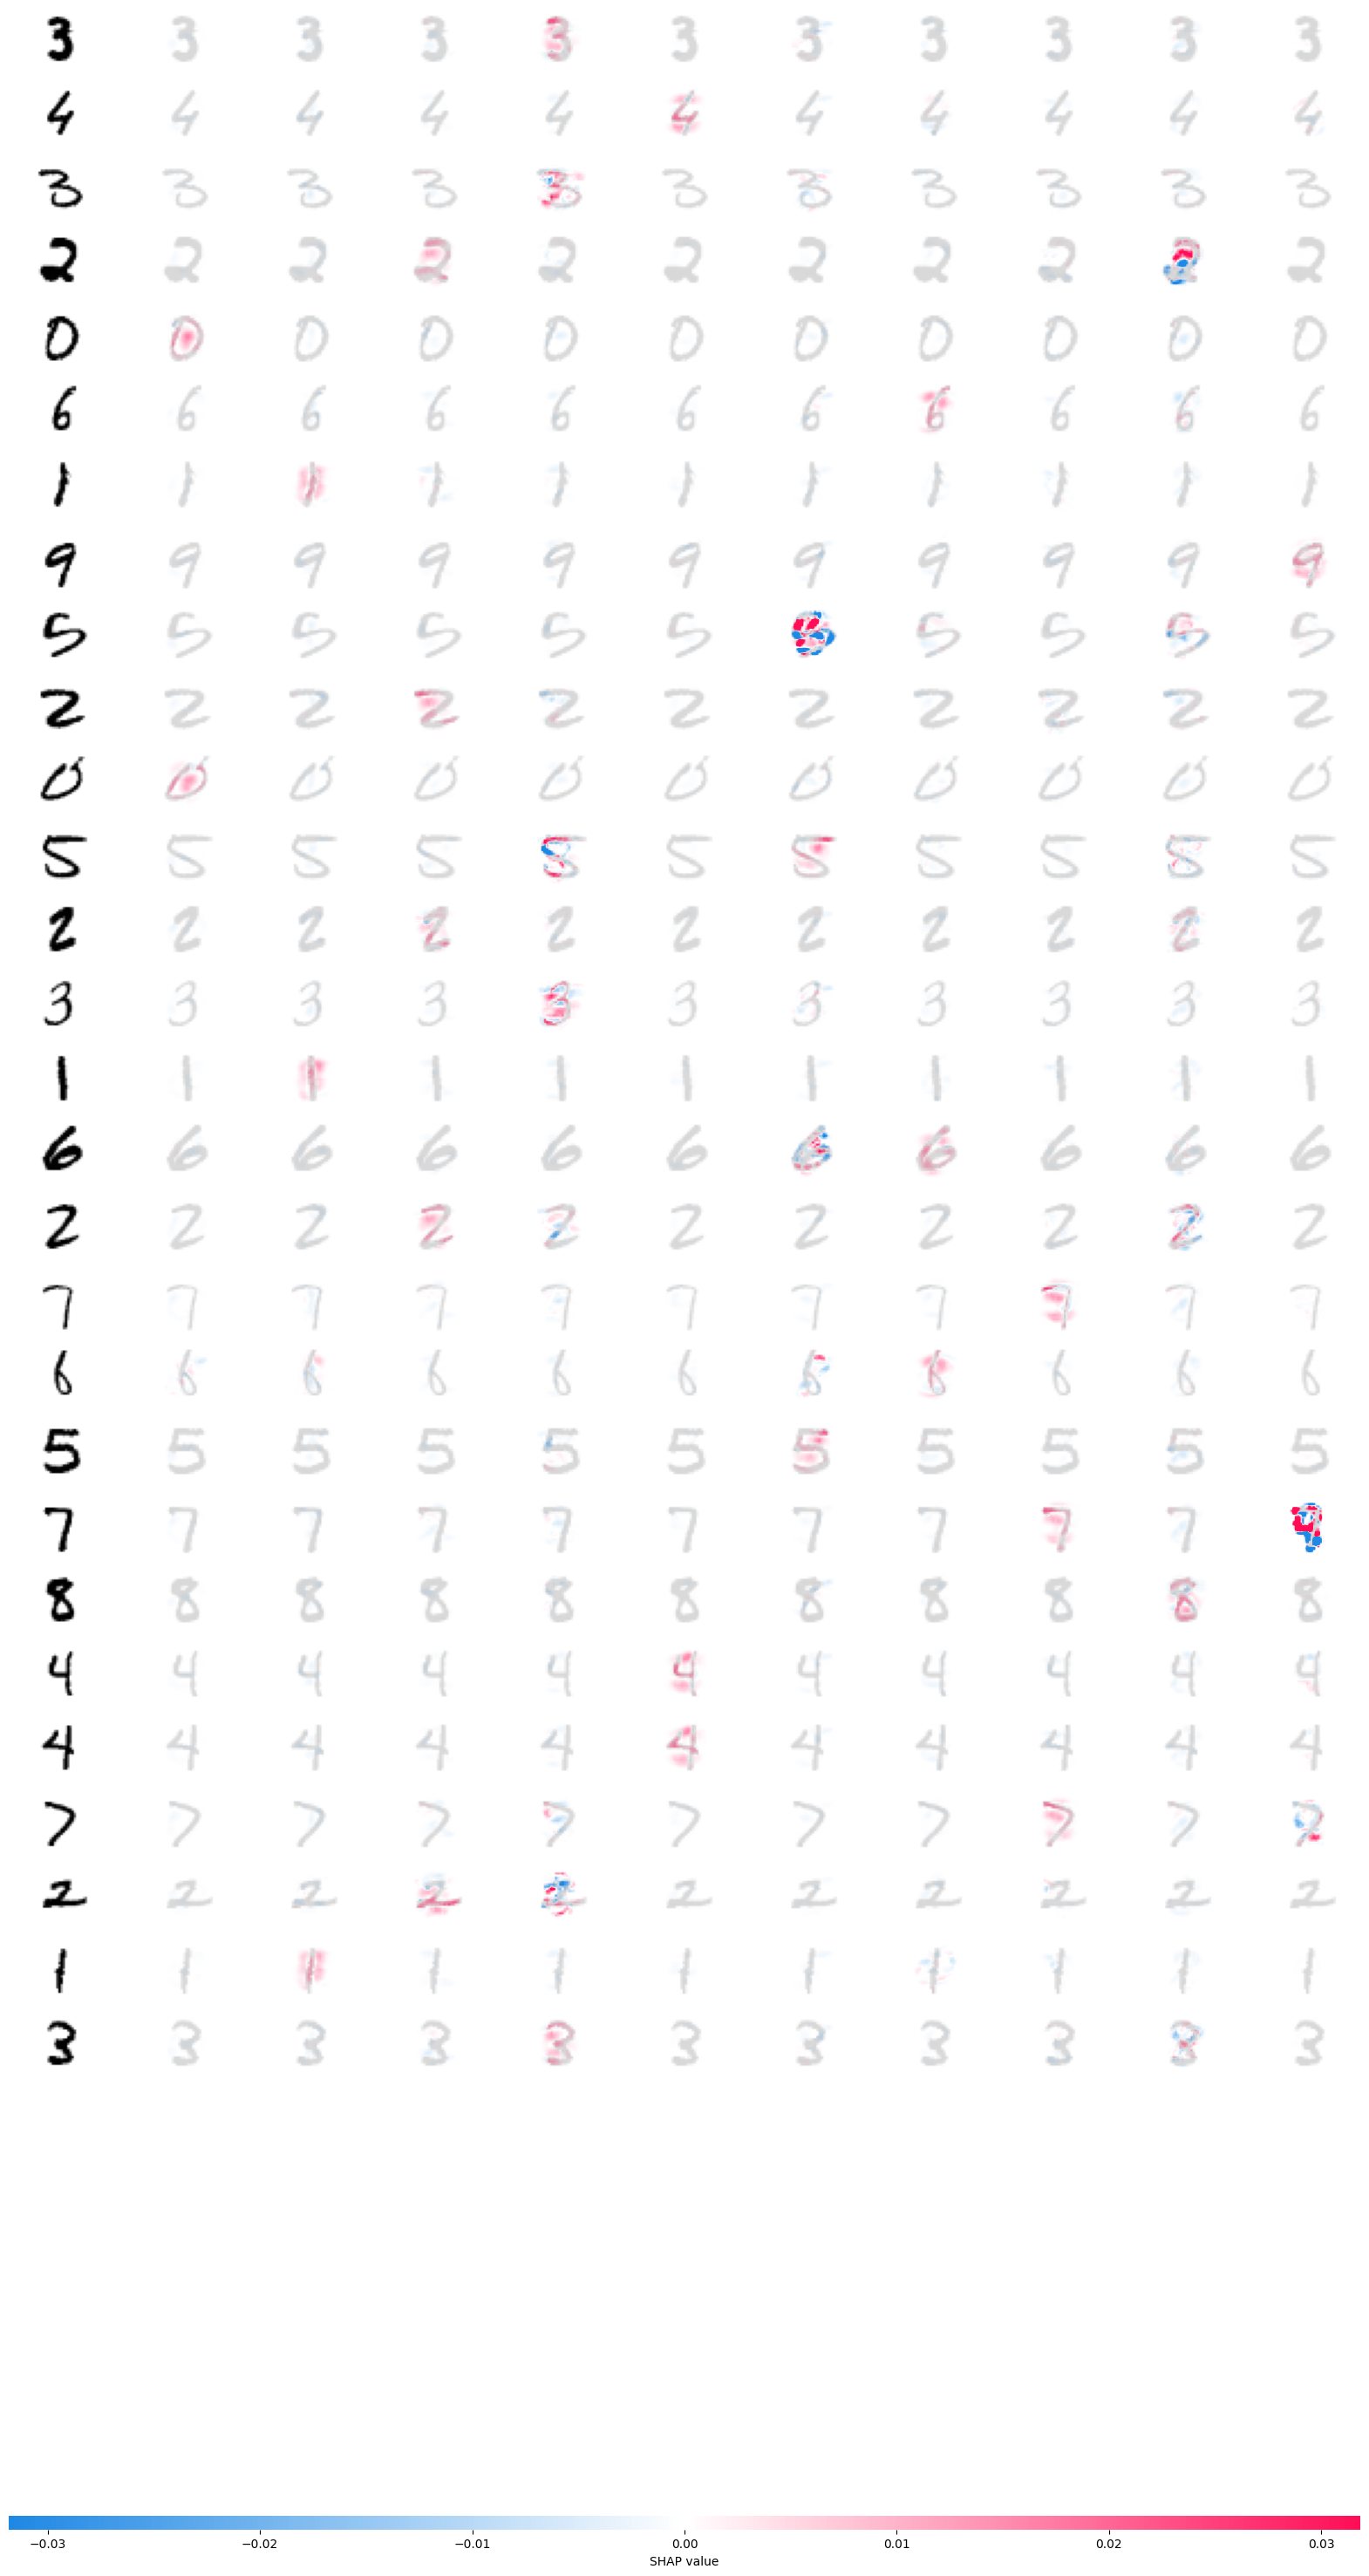

In [ ]:
if TEST_CODE:
    e = shap.DeepExplainer(modelTest, background_images)
    shap_values = e.shap_values(test_images)
    
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)
    
    shap.image_plot(shap_numpy, -test_numpy)